In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


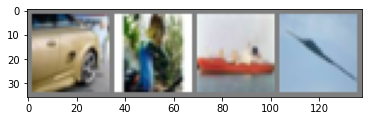

  car  bird  ship plane


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [6]:
class Conv2dF(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input, weight, bias=None, stride=1, padding=0, dilation=1, groups=1):

        ctx.save_for_backward(input, weight, bias)

        return F.conv2d(input, weight, bias, stride, padding, dilation, groups)


    @staticmethod
    def backward(ctx, grad_output):
        input, weight, bias = ctx.saved_variables

        grad_input = grad_weight = grad_bias = None

        if ctx.needs_input_grad[0]:
            grad_input = torch.nn.grad.conv2d_input(input.shape, weight, grad_output)

        if ctx.needs_input_grad[1]:
            grad_weight = torch.nn.grad.conv2d_weight(input, weight.shape, grad_output)

        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0).squeeze(0)

        if bias is not None:
            return grad_input, grad_weight, grad_bias
        else:
            return grad_input, grad_weight

In [ ]:
class Conv2dFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, weight, bias=None, stride=1, padding=0, dilation=1, groups=1):
        # Save arguments to context to use on backward
        # WARNING : if stride, padding, dilation etc is array, this will not work properly!!!!
        confs = torch.from_numpy(np.array([stride, padding, dilation, groups]))
        ctx.save_for_backward(input, weight, bias, confs)

        # Compute Convolution
        return F.conv2d(input, weight, bias=bias, stride=stride, padding=padding, dilation=dilation, groups=groups)
    
    @staticmethod
    def backward(ctx, grad_output):
        # Load saved tensors
        input, weight, bias, confs = ctx.saved_variables
        confs = confs.numpy()
        stride, padding, dilation, groups= confs[0], confs[1], confs[2], confs[3]

        # Calculate Gradient
        grad_input = grad_weight = grad_bias = None
        if ctx.needs_input_grad[0]:
            grad_input = torch.nn.grad.conv2d_input(input.shape, weight, grad_output, stride, padding, dilation, groups)
            
        if ctx.needs_input_grad[1]:
            grad_weight = torch.nn.grad.conv2d_weight(input, weight.shape, grad_output, stride, padding, dilation, groups)
                
        # WARNING : Bias maybe buggy, remove if it is buggy
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0).squeeze(0)


        # WARNING : Bias maybe buggy, remove if it is buggy
        if bias is not None:
            return grad_input, grad_weight, grad_bias, None, None, None, None
        else:
            return grad_input, grad_weight, None, None, None, None, None

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.177
[1,  4000] loss: 1.844
[1,  6000] loss: 1.657
[1,  8000] loss: 1.581
[1, 10000] loss: 1.516
[1, 12000] loss: 1.458
[2,  2000] loss: 1.408
[2,  4000] loss: 1.361
[2,  6000] loss: 1.364
[2,  8000] loss: 1.319
[2, 10000] loss: 1.307
[2, 12000] loss: 1.282
Finished Training


In [8]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %
